# **Cityscapes Dataset**

In this notebook we will explore the cityscapes dataset and build a pyorch dataloader for RGB, Depth, and segmentation


Resource:
- https://www.cityscapes-dataset.com/
- https://arxiv.org/pdf/1604.01685.pdf
- https://github.com/mcordts/cityscapesScripts/tree/master
- https://github.com/mcordts/cityscapesScripts/blob/master/docs/csCalibration.pdf

In [1]:
import os
from glob import glob

import numpy as np
import h5py
import cv2

import torch 
from torch.utils.data import Dataset
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from nyu_dataset import NyuDataset
from utils import *


%matplotlib inline

## Load Dataset

We have stored the cityscapes data in the following structure

- cityscapes
    - disparity
        - train
        - val
        - test
    - gtFine
        - train
        - val
        - test
    - leftImg8bit
        - train
        - val
        - test

In [2]:
root = r"C:\Users\itber\Documents\datasets\cityscapes"

In [18]:
class CityScapes(Dataset):
    def __init__(self, root, split='train', transform=None):
        self.root = root
        self.transform = transform

        self.rgb_paths = glob(os.path.join(root, 'leftImg8bit', split, '**\*.png'))
        self.mask_paths = glob(os.path.join(root, 'gtFine', split, '**\*labelIds.png'))
        self.depth_paths = glob(os.path.join(root, 'disparity', split, '**\*.png'))


    def __getitem__(self, idx):
        rgb_image = cv2.cvtColor(cv2.imread(self.rgb_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_UNCHANGED)
        depth = cv2.imread(self.depth_paths[idx], cv2.IMREAD_UNCHANGED)

        if self.transform:
            # get random state for trasnforms
            state = torch.get_rng_state() 
            rgb_image = self.transform(rgb_image)

            # reset random state to that of the previous transform
            torch.set_rng_state(state) 
            mask = self.transform(mask)

            # reset random state to that of the previous transform
            torch.set_rng_state(state) 
            depth = self.transform(depth)

        # normalize rgb images only if augmentations are applied
        # if self.normalize:
        #     rgb_image = self.normalize(rgb_image)
        #     depth = depth/self.depth_norm
    
        return rgb_image, (mask, depth)

In [19]:
dataset = CityScapes(root)

In [20]:
rgb_image, (mask, disparity) = dataset[13]

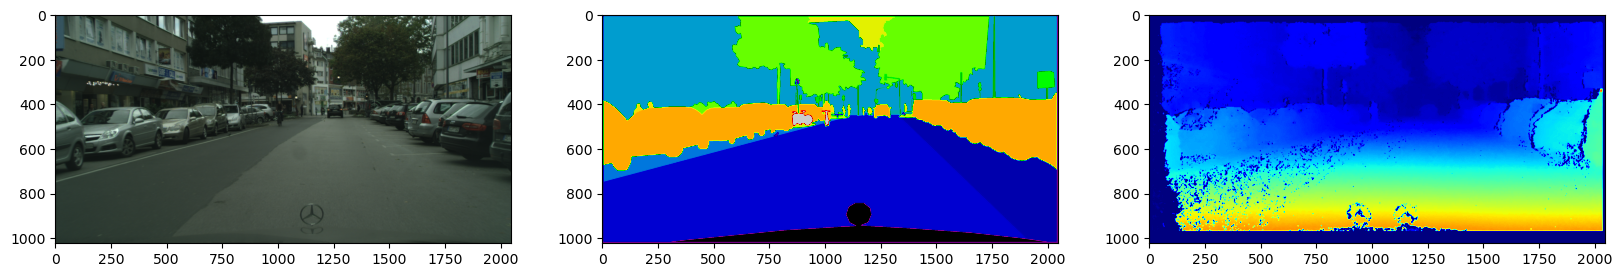

In [28]:
_, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(rgb_image)
ax[1].imshow(mask, cmap='nipy_spectral')
ax[2].imshow(disparity, cmap='jet')

Inpaint depthmap to clean it up

In [59]:
disparity.min(), disparity.max()

(0, 32257)

In [61]:
2**16/2

32768.0

In [44]:
# smooth_disparity = cv2.inpaint(disparity, np.uint8(255*(disparity==0)), inpaintRadius=3, 
#                            flags=cv2.INPAINT_TELEA
#                            # flags=cv2.INPAINT_NS
#                            )

smooth_disparity = cv2.inpaint(disparity, np.uint8(255*(disparity==0)), inpaintRadius=3, 
                           flags=cv2.INPAINT_TELEA
                           # flags=cv2.INPAINT_NS
                           )


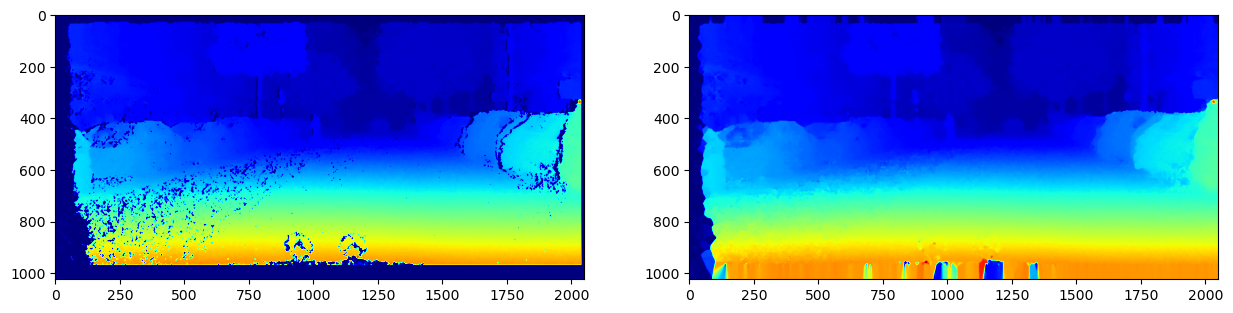

In [45]:
_, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(disparity, cmap='jet')
ax[1].imshow(smooth_disparity, cmap='jet')

Need to invert the disparity to convert it to depth? Or can we get camera infor to get depth?

In [326]:
im_path = r"C:\Users\itber\Documents\datasets\cityscapes\disparity\train\hamburg\hamburg_000000_016928_disparity.png"
disparity = cv2.imread(im_path, cv2.IMREAD_UNCHANGED) # .astype(np.float32)

In [322]:
disparity.dtype, disparity.min(), disparity.max()

(dtype('uint16'), 0, 32257)

In [313]:
h, w = disparity.shape
h2, w2 = int(h*0.8), int(w*0.8)

In [314]:
disparity = cv2.resize(disparity, (w2, h2))
disparity = cv2.inpaint(disparity, np.uint8(255*(disparity==0)), inpaintRadius=1, 
                           flags=cv2.INPAINT_TELEA
                           # flags=cv2.INPAINT_NS
                           )
disparity = cv2.resize(disparity, (w, h))
# disparity = cv2.normalize(disparity, None, alpha=0, beta=32257, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

https://stackoverflow.com/questions/25974033/inpainting-depth-map-still-a-black-image-border

In [ ]:
# double inpaintRadius = 5;
# int makeBorder = 1;
# cv::Mat borderimg;
# cv::copyMakeBorder(img, borderimg, makeBorder, makeBorder, makeBorder, makeBorder, cv::BORDER_REPLICATE);
# cv::imshow("border", borderimg);
# cv::inpaint(borderimg, (borderimg == noDepth), inpainted, inpaintRadius, cv::INPAINT_TELEA); // img is the 8-bit input image (depth map with blank spots)

# cv::Mat originalEmbedded = borderimg(cv::Rect(makeBorder, makeBorder, img.cols, img.rows));
# cv::Mat inpaintedEmbedded = inpainted(cv::Rect(makeBorder, makeBorder, img.cols, img.rows));


In [ ]:
np.random.choice()

In [508]:
left_border = 100
bottom_border = 100
inpaint_radius = 8

# get random image
idx = np.random.choice(np.arange(0, len(dataset.depth_paths)))
im_path = dataset.depth_paths[idx]
rgb_path = dataset.rgb_paths[idx]

# read image
disparity = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)

# get sizes
h, w = disparity.shape
h2, w2 = int(h*0.8), int(w*0.8)

# crop edges
# disparity = disparity[100:-100, 100:-100]

# discard bottom 20% and resize to orignal size
disparity = cv2.resize(disparity[100:h2, 100:], (w,h))

# # replicate along left and bottom
# disparity = cv2.copyMakeBorder(disparity[0:-bottom_border, (left_border - 1):-1], 
#                                top=0, 
#                                bottom=bottom_border, 
#                                left=left_border, 
#                                right=0, 
#                                borderType=cv2.BORDER_REPLICATE)

# inpaint invliad disparity
disparity = cv2.inpaint(disparity, np.uint8(255*(disparity == 0)), inpaintRadius=inpaint_radius, flags=cv2.INPAINT_TELEA)

# disparity = disparity[border:-border, border:-border]


In [509]:
disparity.shape

(1024, 2048)

In [510]:
# disparity[disparity < 0] = 0
disparity.min(), disparity.max()

(0, 25887)

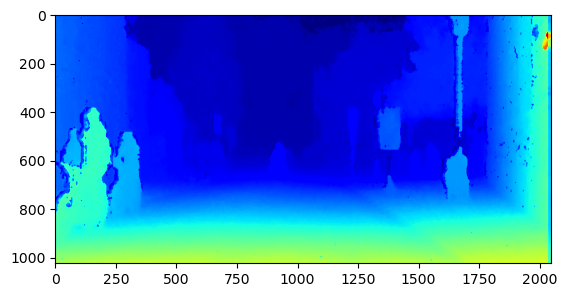

In [511]:
plt.imshow(disparity, cmap='jet')

In [512]:
disparity = disparity.astype(np.float32)
# disp[disp > 0] = (disp[disp > 0] - 1) / 256

# disparity /=disparity.max()
disparity[disparity > 0] = (disparity[disparity > 0] - 1) / 256
# disparity[disparity < 0] = 0

In [513]:
disparity[500, 1000]

4.1757812

In [514]:
disparity.min(), disparity.max()

(0.0, 101.11719)

In [515]:
baseline = 0.209313 # meters

# focal lengths (pixels)
fx = 2262.52 
fy = 2265.3017905988554 

depth = baseline * fx / (disparity + 0.1)

In [516]:
# depth[depth == depth.max()] = 0

In [517]:
depth.min(), depth.max()

(4.6787987, 4735.7485)

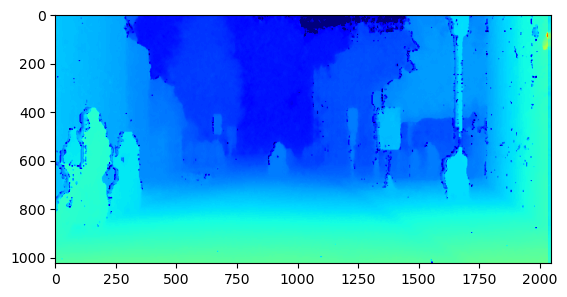

In [518]:
from matplotlib.colors import LogNorm

# plt.imshow(np.clip(depth, 0, 500), cmap='jet_r') #, norm=LogNorm(vmin=0.01, vmax=500)) #, vmax=2)
plt.imshow(depth - depth.min() + 0.01, cmap='jet_r', norm=LogNorm(vmin=0.01, vmax=500))#depth.max()))

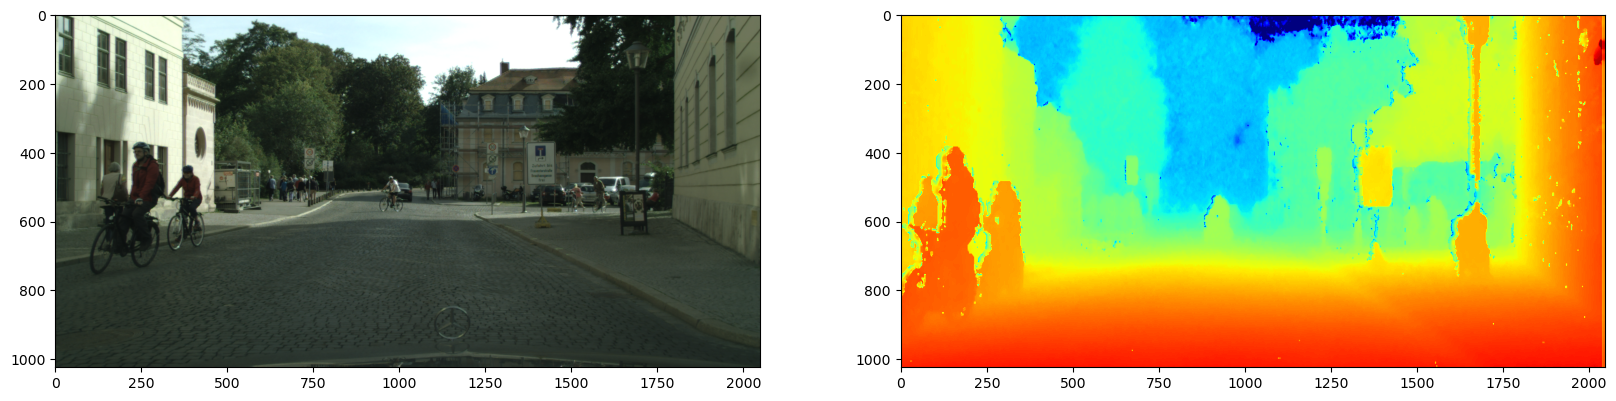

In [527]:
_, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(image)
# ax[1].imshow(np.log(np.clip(depth - depth.min() + 1, 0, 500)), cmap='jet_r')
ax[1].imshow(np.log(np.clip(depth, 0, 500)), cmap='jet_r')